# code2vec using Embeddings and NN

We are going to represent programs as token vectors and learn their representations using embeddings

We are going to create a prediction problem and try to predict whether the program submitted with be considered as correct, i.e. the program pass the testcases specified by the lecturer. Creating a prediction problem to learn representations of the data is a useful approach. There is no easy way to represent these programs so we are going to learn these representations. 
 

* https://code.google.com/archive/p/word2vec/

* https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-pre-trained-glove-word-embeddings-part-3-53fcea9a17fa

* https://www.cse.iitb.ac.in/~pb/papers/bionlp-acl17-medical-coding.pdf

* https://github.com/sloomba/protein2vec

* https://github.com/samiroid/usr2vec

* https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py

* http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/

* Topic Modelling for Humans: https://radimrehurek.com/gensim/

* https://spacy.io/models/

* https://www.shanelynn.ie/get-busy-with-word-embeddings-introduction/

* Code2Vec https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8031179&tag=1, https://arxiv.org/pdf/1803.09473.pdf, https://code2vec.org/

* From People2Vec to Emotional AI: http://people2vec.org/

* Using Word2vec for Music Recommendations: https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484

* Source code identifier embeddings: https://blog.sourced.tech/post/id2vec/

* Recommending Recommendation Systems: https://gab41.lab41.org/recommending-recommendation-systems-cc39ace3f5c1, https://github.com/Lab41/Misc/blob/master/blog/python2vec/Python2Vec%20Example.ipynb

* Python2Vec: Word Embeddings for Source Code: https://gab41.lab41.org/python2vec-word-embeddings-for-source-code-3d14d030fe8f

* Anything2Vec: https://gab41.lab41.org/anything2vec-e99ec0dc186

* AutoKeras: https://towardsdatascience.com/autokeras-the-killer-of-googles-automl-9e84c552a319, https://autokeras.com/

* Learning Program Embeddings to Propagate Feedback on Student Code: https://web.stanford.edu/~cpiech/bio/papers/programEncoding.pdf, https://github.com/chrispiech/refactoredEncoder

* Research at Code.org: https://code.org/research

* Cheatsheet: https://startupsventurecapital.com/essential-cheat-sheets-for-machine-learning-and-deep-learning-researchers-efb6a8ebd2e5

* DCU Deep Learning Summer School: https://telecombcn-dl.github.io/2018-dlcv/, https://www.slideshare.net/xavigiro/d1l2-the-neural-network-zoo-upc-2018-deep-learning-for-computer-vision

* Embeddings: https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
font = {'weight': 'bold', 'size': 20}
plt.rc('font', **font)

## VECTORIZE

**Programming data**: Student develop programs locally for the laboratory sheets of computer programming courses at our university. These programs are submitted by them to an automatic grading platform that runs some test cases specified by the lecturer on each program. A JSON output for those testcases and whether the program passed them or not along with the actual code is stored.

In [3]:
!ls data/raw/programming_data.json

data/raw/programming_data.json


In [4]:
dataframe = pd.read_json('data/raw/programming_data.json')

In [5]:
dataframe.head(2)

,academic_year_0,academic_year_1,correct,date,extension,ip,module,task,upload,user
0,2016,2017,True,2016-09-19 14:11:41,py,,ca277,add.py,#!/usr/bin/env python\n\na = int(raw_input())\...,b9e7e608-6036-4d44-8770-a7036176b53c
1,2016,2017,True,2016-09-19 14:17:33,py,,ca277,concat-lines.py,#!/usr/bin/env python\n\na = str(raw_input())\...,b9e7e608-6036-4d44-8770-a7036176b53c


In [6]:
'{:,}'.format(len(dataframe))

'591,707'

Grab only code submissions from Python modules:

In [7]:
PYTHON_MODULES = [
    'ca116', 
    'ca117', 
    'ca177', 
    'ca277', 
    'ca278',
]

In [8]:
dataframe = dataframe[dataframe['module'].isin(PYTHON_MODULES)]

In [9]:
'{:,}'.format(len(dataframe))

'490,820'

Target value:

In [10]:
dataframe.correct.value_counts()

False    296369
True     194451
Name: correct, dtype: int64

Remove comments:

In [11]:
import re
def remove_comments(text):
    return re.sub(re.compile('#.*?\n'), '', text)

Grab docs (code submissions) and labels (correct or not):

In [12]:
def get_docs_and_labels(df):
    _docs = []
    _labels = []
    for index in df.index:
        # Program
        code = remove_comments(
            df.at[index, 'upload']
        )
        _docs.append(code)
        # Label
        label = int(df.at[index, 'correct'])
        _labels.append(label)
    return _docs, _labels

In [13]:
docs, labels = get_docs_and_labels(dataframe)

In [14]:
'{:,}'.format(len(docs))

'490,820'

In [15]:
docs[0]

u'\na = int(raw_input())\nb = int(raw_input())\n\nprint a + b\n\n\n'

In [16]:
labels[0]

1

## 1) Programs as word vectors

https://faroit.github.io/keras-docs/1.2.2/preprocessing/text/

In [17]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [18]:
NUM_WORDS = 2000 # Originally 231,659 words

In [19]:
def get_tokenizer():

    return Tokenizer(num_words=NUM_WORDS, 
                     filters='\t\n', 
                     lower=True, 
                     split=' ', 
                     char_level=False)

In [20]:
word_t = get_tokenizer()

In [21]:
word_t.fit_on_texts(docs)

In [22]:
# word_counts: a dictionary of words and their counts.
word_t.word_counts['if'] # word count

552539

In [23]:
# document_count: an integer count of the total number of documents that were used to fit the Tokenizer.
'Number docs: {:,}'.format(word_t.document_count)

'Number docs: 490,820'

In [24]:
# word_index: a dictionary of words and their uniquely assigned integers.
word_t.word_index['if'] # index

4

In [25]:
# word_docs: a dictionary of words and how many documents each appeared in.
word_t.word_docs['if']

298487

In [26]:
import pickle

with open('word_tokenizer.pickle', 'wb') as handle:
    pickle.dump(word_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
sequences = word_t.texts_to_sequences(docs)

In [28]:
sequences[0]

[17, 1, 358, 50, 1, 358, 6, 17, 3, 50]

Look at the lenght of these sequences:

In [29]:
len_seqs = [len(s) for s in sequences]

In [30]:
np.mean(len_seqs), np.std(len_seqs), np.max(len_seqs)

(38.591420480013042, 38.577314137088699, 2358)

In [31]:
MAX_LENGTH = 50

Dictionary to transform a vector back to the program:

In [32]:
id_to_word = { v: k for k, v in word_t.word_index.items() }

In [33]:
id_to_word[1]

u'='

In [34]:
[id_to_word[index] for index in sequences[0]]

[u'a',
 u'=',
 u'int(raw_input())',
 u'b',
 u'=',
 u'int(raw_input())',
 u'print',
 u'a',
 u'+',
 u'b']

Pad documents:

In [35]:
from keras.preprocessing.sequence import pad_sequences

In [36]:
# pad documents
padded_docs = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

In [37]:
padded_docs[0]

array([ 17,   1, 358,  50,   1, 358,   6,  17,   3,  50,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

Model:

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [39]:
def get_model():

    # define the model
    model = Sequential()
    model.add(Embedding(NUM_WORDS, 100, input_length=MAX_LENGTH))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # summarize the model
    print(model.summary())
    return model

In [40]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5001      
Total params: 205,001
Trainable params: 205,001
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
# fit the model
# model.fit(padded_docs, labels, epochs=2, verbose=1)

model.fit(padded_docs, 
          labels,
          batch_size=128,
          epochs=2,
          validation_split=0.2)

Train on 392656 samples, validate on 98164 samples
Epoch 1/2
392656/392656 [==============================] - 25s 63us/step - loss: 0.5927 - acc: 0.6771 - val_loss: 0.6566 - val_acc: 0.6348
Epoch 2/2
392656/392656 [==============================] - 22s 57us/step - loss: 0.5325 - acc: 0.7258 - val_loss: 0.6993 - val_acc: 0.6367


In [42]:
# evaluate the model
word_loss, word_accuracy = model.evaluate(padded_docs, labels, verbose=1)
print('Accuracy: %f, Loss: %f' % (word_accuracy * 100, word_loss * 100))

490820/490820 [==============================] - 19s 40us/step
Accuracy: 72.730329, Loss: 53.976663


In [129]:
word_score = {
    'accuracy': word_accuracy,
    'loss': word_loss,
}
embeddings_scores = { 'Word': word_score }

In [43]:
def get_embeddings(model):

    # Embedding Layer
    embedding_layer = model.layers[0]
    embeddings = embedding_layer.get_weights()[0]
    print 'Embedding Layer shape:', embeddings.shape
    
    return embeddings

In [44]:
embeddings = get_embeddings(model)

Embedding Layer shape: (2000, 100)


In [45]:
embeddings[0]

array([  1.30102616e-02,  -3.31541849e-03,   9.20820236e-03,
        -4.04026266e-03,   1.37938187e-02,  -2.96938233e-04,
        -8.87724105e-03,   1.51044196e-02,  -6.70031877e-03,
         2.02970095e-02,   1.15323570e-02,   1.76684689e-02,
        -3.29914736e-03,  -1.51842125e-02,   3.41158593e-03,
         7.59929046e-03,   1.22711547e-02,   2.44561639e-02,
         9.63928085e-03,   9.22557339e-03,  -6.89324271e-03,
         1.71551798e-02,  -2.49174032e-02,  -3.62910912e-03,
        -1.65731963e-02,   1.01133706e-02,   8.19548685e-03,
        -1.18395686e-02,   9.53381043e-03,  -1.19683081e-02,
         2.01584361e-02,   8.54355749e-03,   3.25581233e-04,
        -1.14840148e-02,  -1.41051784e-03,   1.49482733e-03,
         1.63588189e-02,   1.82347242e-02,   2.05257945e-02,
        -1.93947591e-02,   7.31566316e-03,   1.83650281e-03,
        -1.49149857e-02,  -7.32003478e-03,  -2.60862410e-02,
         6.50073634e-03,  -2.67010443e-02,   9.72012337e-03,
         7.98153575e-04,

In [46]:
# np.save('data/processed/word_embeddings', embeddings)

In [47]:
from sklearn.decomposition import PCA

def get_pca(embeddings):

    # PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(embeddings)
    print 'PCA explained variance ratio:', pca.explained_variance_ratio_, 'Total:', sum(pca.explained_variance_ratio_)
    return principal_components

In [48]:
pca = get_pca(embeddings)

PCA explained variance ratio: [ 0.17617509  0.06023274] Total: 0.236407823861


In [49]:
def get_top_words(tokenizer, N=50):
    
    return [word for word, occurrences in sorted(tokenizer.word_counts.items(), key=lambda t: t[1], reverse=True)[:N]]

In [50]:
top_words = get_top_words(word_t)

In [51]:
def plot_embeddings(low_dim_embs, id_to_word, top_words, figsize=(8, 8)):

    plt.figure(figsize=figsize, dpi=100)
    ax = plt.axes()
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_locator(plt.NullLocator())
    i = 0
    while i < len(low_dim_embs):

        if i in id_to_word:
            
            x, y = low_dim_embs[i, :]
            word = id_to_word[i]

            if word in top_words:
                plt.scatter(x, y, color='b')
                plt.annotate(word,
                            xy=(x, y),
                            xytext=(5, 2),
                            textcoords='offset points',
                            ha='right',
                            va='bottom',
                            fontsize=14)
        
        i += 1

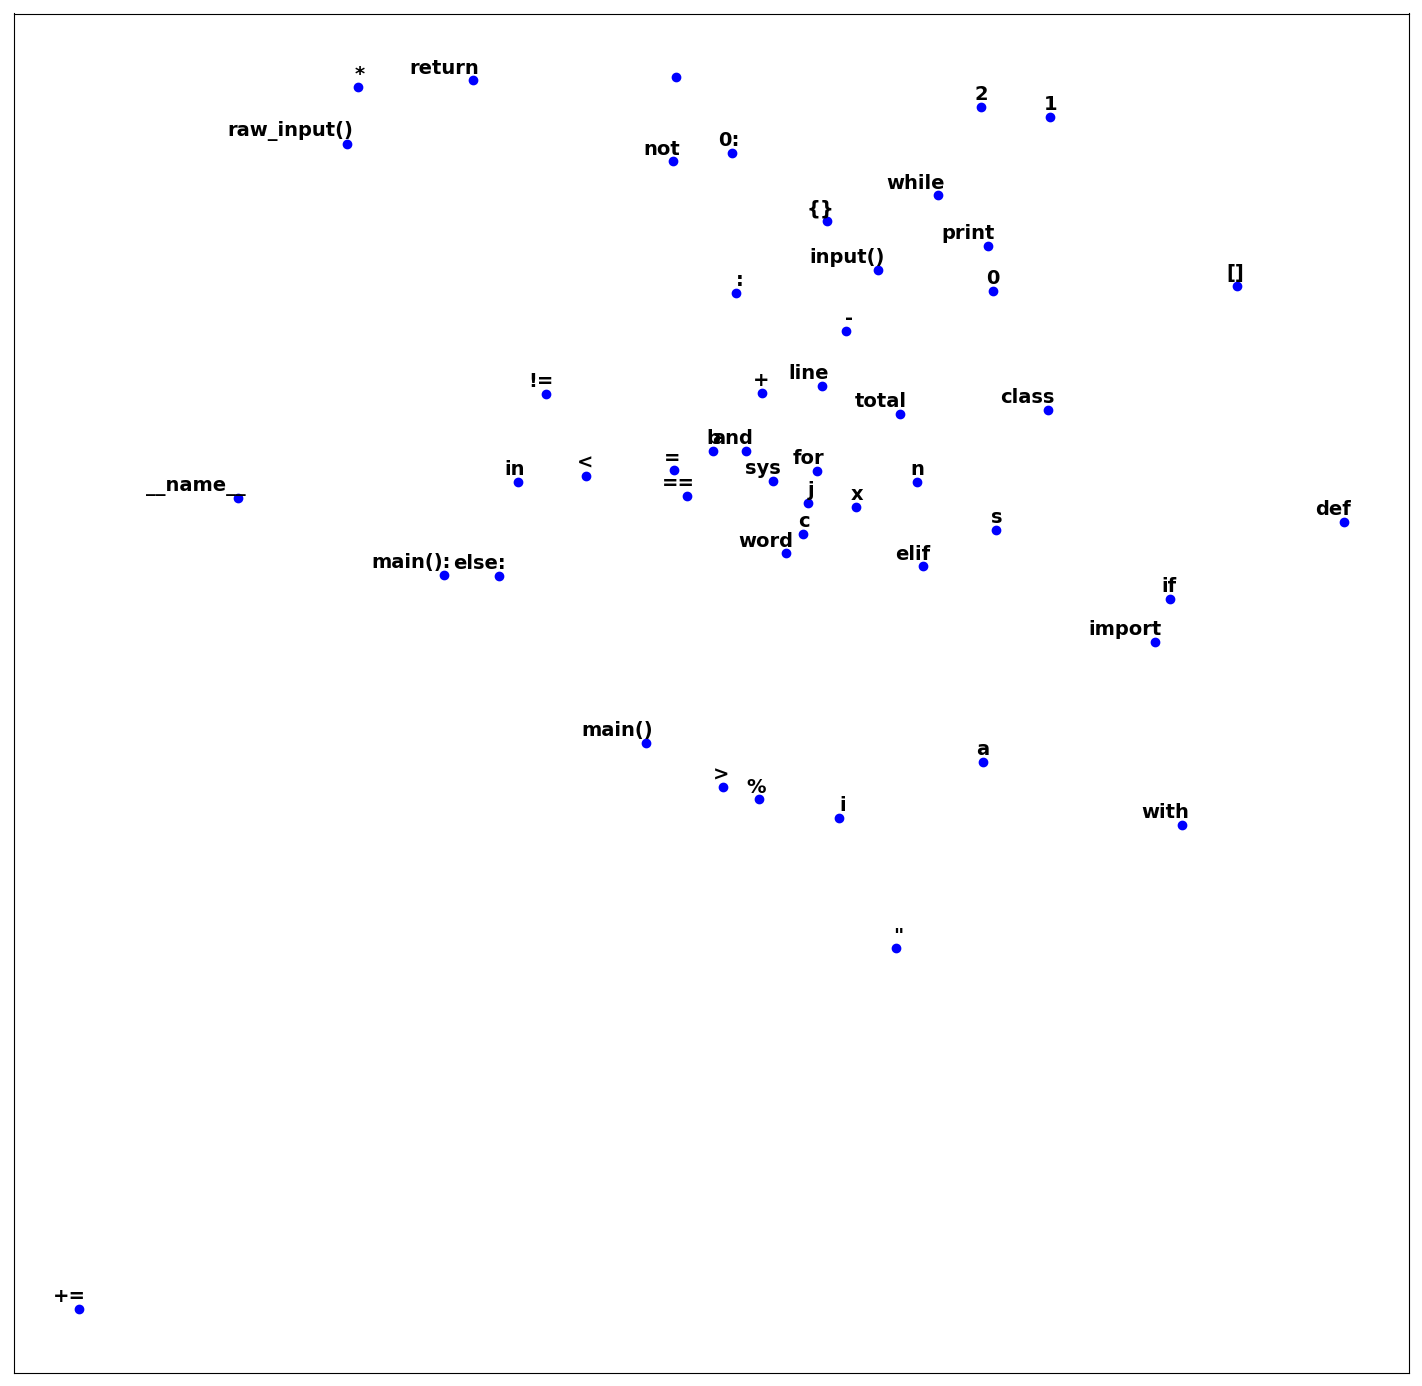

In [52]:
plot_embeddings(pca, id_to_word, top_words, figsize=(18, 18))

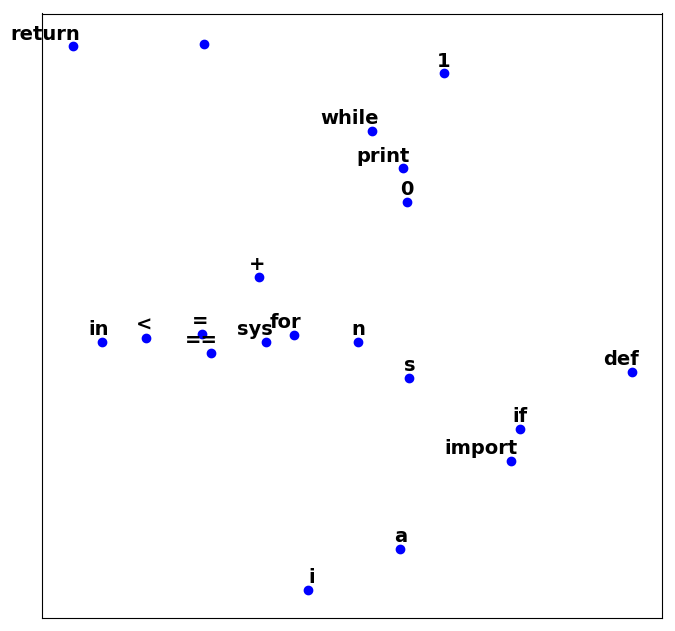

In [53]:
plot_embeddings(pca, id_to_word, get_top_words(word_t, 20))

Measure the distance between vectors:

In [54]:
from scipy.spatial.distance import euclidean, cosine

def get_vector_distance(embeddings, tok, word1, word2):
    
    return euclidean(embeddings[tok.word_index[word1]], 
                     embeddings[tok.word_index[word2]])
    
def get_vector_cosine_distance(embeddings, tok, word1, word2):
    
    return cosine(embeddings[tok.word_index[word1]], 
                  embeddings[tok.word_index[word2]])

Cosine similarity:

In [55]:
get_vector_cosine_distance(embeddings, word_t, '<', '>')

1.0449721736428432

In [56]:
get_vector_cosine_distance(embeddings, word_t, 'elif', 'else:')

0.98390098108647339

In [57]:
get_vector_cosine_distance(embeddings, word_t, '+', '-')

0.85684510467589892

Euclidean distance:

In [58]:
get_vector_distance(embeddings, word_t, '<', '>')

0.8382436037063599

In [59]:
get_vector_distance(embeddings, word_t, '==', '!=')

0.7284256815910339

In [60]:
get_vector_distance(embeddings, word_t, 'if', 'elif')

0.8253481984138489

In [61]:
get_vector_distance(embeddings, word_t, 'elif', 'else:')

0.8891847133636475

In [62]:
get_vector_distance(embeddings, word_t, '+', '-')

0.8000079393386841

In [63]:
get_vector_distance(embeddings, word_t, 'for', 'while')

0.6813578605651855

In [64]:
get_vector_distance(embeddings, word_t, 'def', 'import')

0.6512326002120972

In [65]:
def get_neighbors(word, emb, tok, id_to_item, top_n=5):

    dist = {}
    i = 0
    while i < len(emb):

        if i in id_to_item:
            w = id_to_item[i]
            if w != word:
                dist[w] = get_vector_cosine_distance(emb, tok, word, w)
        
        i += 1

    for key, value in sorted(dist.iteritems(), key=lambda (k,v): (v,k), reverse=True)[:top_n]:
        print "%s: %s" % (key, value)

In [66]:
get_neighbors('if', embeddings, word_t, id_to_word)

world.\n"): 1.62704056389
p,: 1.6179079049
swap_unique_keys_values(d):: 1.59880462936
sys.argv[1]: 1.58544437584
l[0]: 1.5789156993


In [67]:
get_neighbors('+', embeddings, word_t, id_to_word)

[i: 1.48325386585
print("you: 1.47351591906
[w: 1.46080445422
every: 1.45035726578
wins: 1.44243310929


In [68]:
get_neighbors('for', embeddings, word_t, id_to_word)

s[0]: 1.47042120199
s[:-1]: 1.45301138812
100: 1.42042907078
disqualified: 1.39984575832
"nine",: 1.3685045652


In [69]:
get_neighbors('1', embeddings, word_t, id_to_word)

"\n"): 1.55132502059
filename: 1.54673524813
__init__(self: 1.54336464257
bankaccount.total_lodgements: 1.53875589508
fruit:: 1.5233551874


In [70]:
get_neighbors('def', embeddings, word_t, id_to_word)

wages(self):: 1.64791392698
p,: 1.64416701535
{:.2f}".format(self.name,: 1.63754282314
a.append(int(line)): 1.602403659
points=0):: 1.60234031477


## 2) Programs as tokens

In [71]:
from tokenize import generate_tokens
from StringIO import StringIO

In [72]:
token_ids = []
token_words = []
token_labels = []
i = 0
while i < len(docs):
    doc = docs[i]
    label = labels[i]
    try:
        tokens = [(t[0], t[1]) for t in list(generate_tokens(StringIO(doc).readline))]
        # Token ID
        token_ids.append(
            [token[0] for token in tokens]
        )
        # Token
        token_words.append(
            [token[1] for token in tokens]
        )
        token_labels.append(
            label
        )
    except:
        pass
    i += 1

### 2.1) Token words

In [73]:
'Number encoded docs: {:,}'.format(len(token_words))

'Number encoded docs: 472,087'

In [74]:
token_docs = [
    ' '.join(array) for array in token_words
]

In [75]:
token_t = get_tokenizer()

token_t.fit_on_texts(token_docs)

In [76]:
# saving
with open('token_tokenizer.pickle', 'wb') as handle:
    pickle.dump(token_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [77]:
token_sequences = token_t.texts_to_sequences(token_docs)

id_to_token = { v: k for k, v in token_t.word_index.items() }

token_padded_docs = pad_sequences(token_sequences, maxlen=MAX_LENGTH, padding='post')

In [78]:
token_model = get_model()

token_model.fit(token_padded_docs, 
                token_labels,
                batch_size=128,
                epochs=2,
                validation_split=0.2)

token_loss, token_accuracy = token_model.evaluate(token_padded_docs, token_labels, verbose=1)
print('Accuracy: %f, Loss: %f' % (token_accuracy * 100, token_loss * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5001      
Total params: 205,001
Trainable params: 205,001
Non-trainable params: 0
_________________________________________________________________
None
Train on 377669 samples, validate on 94418 samples
Epoch 1/2
377669/377669 [==============================] - 22s 57us/step - loss: 0.5772 - acc: 0.6927 - val_loss: 0.6660 - val_acc: 0.6351
Epoch 2/2
472087/472087 [==============================] - 17s 36us/step
Accuracy: 74.195858, Loss: 51.984684


In [130]:
token_score = {
    'accuracy': token_accuracy,
    'loss': token_loss,
}
embeddings_scores['Word Token'] = token_score

In [79]:
token_embeddings = get_embeddings(token_model)

token_embeddings[0]

Embedding Layer shape: (2000, 100)


array([  3.50252725e-03,   1.37998462e-02,  -1.77380234e-01,
         6.35293052e-02,   6.03527250e-03,  -6.78978115e-02,
        -3.91467242e-03,  -5.26777208e-02,  -7.68449455e-02,
         8.33068714e-02,   2.23422889e-02,   2.46576946e-02,
         1.09764576e-01,  -7.63060851e-03,  -1.27133995e-01,
         1.69861857e-02,  -2.79654600e-02,  -7.48254359e-03,
        -8.39845836e-02,   3.22490768e-03,   1.78193171e-02,
         5.37862489e-03,  -3.68050709e-02,   1.25979783e-03,
        -1.19293589e-04,   2.37874892e-02,  -7.84554705e-03,
        -2.83123180e-02,   3.64997238e-02,   7.29747675e-03,
        -1.14062214e-02,   5.98050021e-02,  -4.00535092e-02,
         6.34413026e-03,  -3.04493643e-02,  -1.40111344e-02,
        -4.92205247e-02,   1.59549303e-02,   4.84804995e-02,
        -2.39058025e-02,  -3.50580029e-02,   4.02900651e-02,
        -2.82534882e-02,   2.89389715e-02,  -2.03504134e-02,
         5.51030301e-02,   3.41624133e-02,   2.56372131e-02,
         7.75925862e-03,

In [80]:
# np.save('data/processed/token_embeddings', token_embeddings)

In [81]:
token_pca = get_pca(token_embeddings)

token_top_words = get_top_words(token_t, N=100)

PCA explained variance ratio: [ 0.19701943  0.0628709 ] Total: 0.259890332818


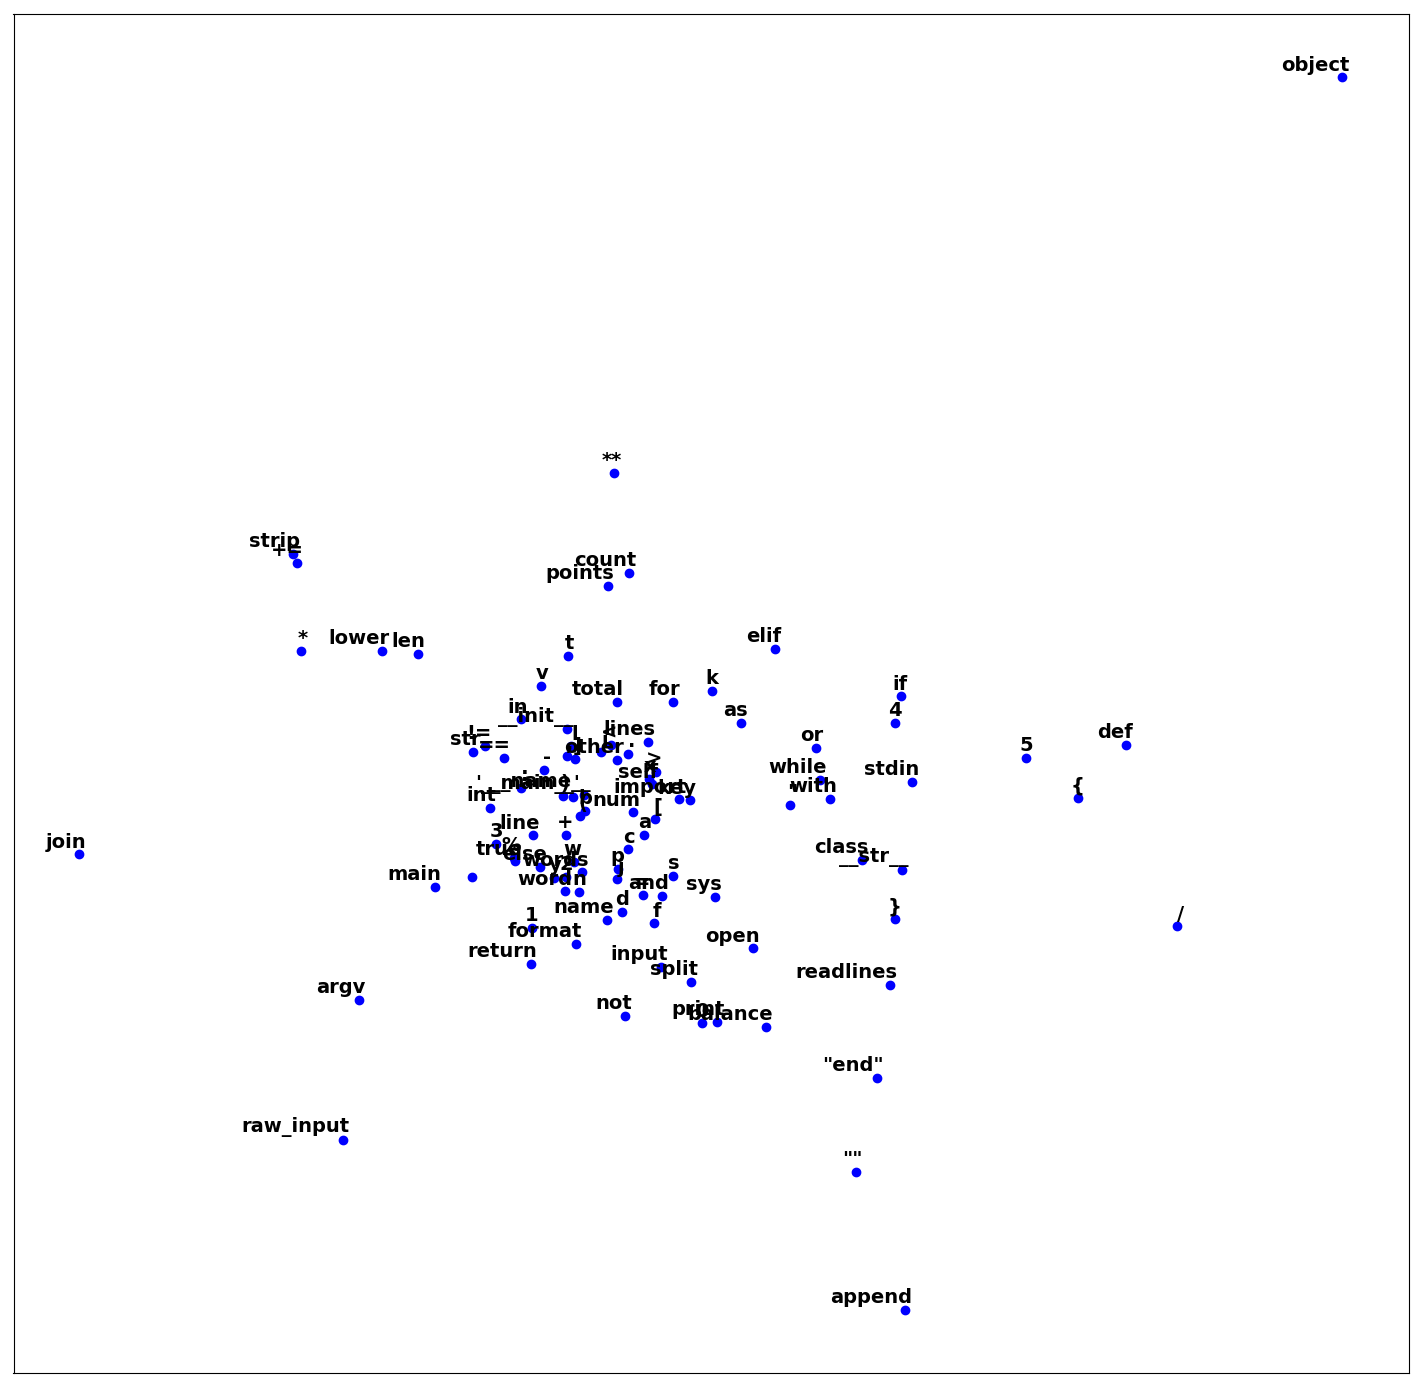

In [82]:
plot_embeddings(token_pca, id_to_token, token_top_words, figsize=(18, 18))

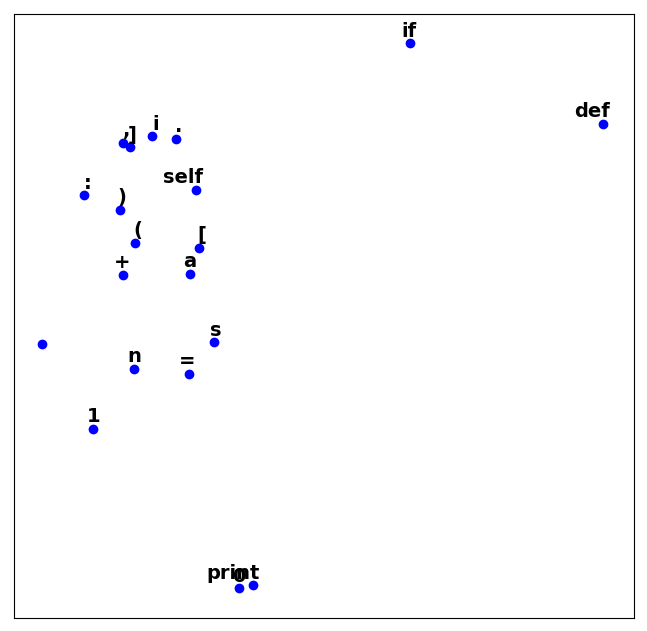

In [83]:
plot_embeddings(token_pca, id_to_token, get_top_words(token_t, 20))

Distances:

In [84]:
get_vector_cosine_distance(token_embeddings, token_t, '<', '>')

0.99465388651841902

In [85]:
get_vector_cosine_distance(token_embeddings, token_t, '+', '-')

0.95332349164319363

In [86]:
get_vector_cosine_distance(token_embeddings, token_t, 'if', 'elif')

0.77960699603989969

In [87]:
get_vector_cosine_distance(token_embeddings, token_t, 'elif', 'else')

0.95547929308587809

In [88]:
get_vector_cosine_distance(token_embeddings, token_t, '}', ']')

1.0165046758931975

In [89]:
# vector('Paris') - vector('France') + vector('Italy') results in a vector that is very close to vector('Rome')
vector = np.add( 
    np.subtract(token_embeddings[token_t.word_index['elif']], token_embeddings[token_t.word_index['else']]),
    token_embeddings[token_t.word_index['}']]
)

print euclidean(token_embeddings[token_t.word_index[']']], 
                vector)        

1.80965220928


In [90]:
get_vector_cosine_distance(token_embeddings, token_t, 'for', 'while')

0.63660124350939573

In [91]:
get_vector_cosine_distance(token_embeddings, token_t, '{', '}')

0.52827423605107804

In [92]:
get_vector_cosine_distance(token_embeddings, token_t, '(', ')')

1.0166489920702746

In [93]:
get_vector_cosine_distance(token_embeddings, token_t, '[', ']')

1.0954532838549504

Euclidean:

In [94]:
get_vector_distance(token_embeddings, token_t, '<', '>')

1.1083074808120728

In [95]:
get_vector_distance(token_embeddings, token_t, '+', '-')

0.9957721829414368

In [96]:
get_vector_distance(token_embeddings, token_t, '==', '!=')

0.8986144065856934

In [97]:
get_vector_distance(token_embeddings, token_t, 'if', 'elif')

1.1148247718811035

In [98]:
get_vector_distance(token_embeddings, token_t, 'elif', 'else')

1.1448495388031006

In [99]:
get_vector_distance(token_embeddings, token_t, '*', '/')

2.555802345275879

In [100]:
get_vector_distance(token_embeddings, token_t, 'for', 'while')

0.9365643262863159

In [101]:
get_vector_distance(token_embeddings, token_t, '{', '[')

1.4555065631866455

In [102]:
get_vector_cosine_distance(token_embeddings, token_t, '{', '[')

0.78183354080901257

In [103]:
get_vector_distance(token_embeddings, token_t, '}', ']')

1.1523090600967407

In [104]:
get_vector_distance(token_embeddings, token_t, '[', ']')

0.7306205034255981

In [106]:
get_vector_distance(token_embeddings, token_t, '(', ')')

0.4645760953426361

Neighbors:

In [107]:
get_neighbors('if', token_embeddings, token_t, id_to_token, top_n=10)

{:.2f}': 1.66944176847
divide: 1.63787970304
e1: 1.62408741029
living.": 1.62176179645
{:>15.2f}: 1.58671578934
equal_to: 1.58312606881
{:.1f}": 1.58232620154
".bak": 1.57921285412
show_student: 1.56850769681
'fred': 1.56535221157


In [108]:
get_neighbors('for', token_embeddings, token_t, id_to_token)

"even": 1.52608281357
fibonacci: 1.50162810774
"fizzbuzz": 1.49058781666
fare: 1.48214210252
tmp2: 1.40889150385


In [109]:
get_neighbors('i', token_embeddings, token_t, id_to_token, top_n=10)

s1: 1.48437084377
format: 1.47078789305
surname: 1.41732428553
'.': 1.4073449969
f_b: 1.40674228364
40000: 1.40470425773
aline: 1.39713400153
11: 1.39432940264
{:.2f}": 1.38857362084
primes: 1.38657492375


In [110]:
get_neighbors('print', token_embeddings, token_t, id_to_token, top_n=10)

dot: 1.60458909658
bytes': 1.58003548737
are.": 1.53068326288
ds: 1.52134057351
point2: 1.51433419102
honours: 1.50710230924
{}\nnumber:: 1.50530261317
opened.": 1.50490101344
break: 1.49433085866
'qu': 1.47985844695


In [111]:
get_neighbors('1', token_embeddings, token_t, id_to_token, top_n=20)

"february": 1.53346277083
runner: 1.53137704581
isdigit: 1.52681006527
grace.": 1.50569648718
permis: 1.50281200959
wordcount: 1.49707801488
"four": 1.49176259432
hundred": 1.48777567213
'id:: 1.46974089138
'words: 1.46080187784
letters:': 1.46052668086
'february': 1.45738349612
students: 1.45562939873
'please: 1.45047444453
free: 1.44880977862
{:<3}: 1.44332354526
"translation.txt": 1.43676603612
"ch": 1.43522578026
union: 1.43389839781
mile: 1.43317417357


### 2.2) Token categories

In [112]:
'Number encoded docs: {:,}'.format(len(token_ids))

'Number encoded docs: 472,087'

In [113]:
token_ids = [
    ' '.join([str(a) for a in array]) for array in token_ids
]

In [114]:
category_t = get_tokenizer()

category_t.fit_on_texts(token_ids)

In [115]:
# saving
with open('category_tokenizer.pickle', 'wb') as handle:
    pickle.dump(category_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [116]:
category_sequences = category_t.texts_to_sequences(token_ids)

id_to_category = { v: k for k, v in category_t.word_index.items() } # GET THE NAMES here for each category number?

category_padded_docs = pad_sequences(category_sequences, maxlen=MAX_LENGTH, padding='post')

In [117]:
category_model = get_model()

category_model.fit(category_padded_docs, 
                   token_labels,
                   batch_size=128,
                   epochs=2,
                   validation_split=0.2)

cat_loss, cat_accuracy = token_model.evaluate(category_padded_docs, token_labels, verbose=1)
print('Accuracy: %f, Loss: %f' % (token_accuracy * 100, token_loss * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5001      
Total params: 205,001
Trainable params: 205,001
Non-trainable params: 0
_________________________________________________________________
None
Train on 377669 samples, validate on 94418 samples
Epoch 1/2
377669/377669 [==============================] - 20s 53us/step - loss: 0.6665 - acc: 0.5988 - val_loss: 0.6510 - val_acc: 0.6296
Epoch 2/2
472087/472087 [==============================] - 18s 38us/step
Accuracy: 74.195858, Loss: 51.984684


In [131]:
category_score = {
    'accuracy': cat_accuracy,
    'loss': cat_loss,
}
embeddings_scores['Category Token'] = category_score

In [118]:
category_embeddings = get_embeddings(category_model)

category_embeddings[0]

Embedding Layer shape: (2000, 100)


array([ -4.66358196e-03,  -1.22231629e-03,  -1.19618662e-02,
         2.32440680e-02,   2.83180736e-02,   3.02692037e-03,
         9.83100478e-03,  -3.12851812e-03,  -1.03556989e-02,
         2.78051989e-03,   2.11337842e-02,  -2.17873417e-02,
        -3.26872338e-03,   1.31304264e-02,  -1.24341622e-02,
        -5.47411910e-04,  -1.08766248e-02,  -4.51148860e-03,
         4.29796707e-03,   5.31856567e-02,  -2.83434708e-03,
        -1.15630049e-02,   5.51912049e-03,  -2.82078162e-02,
         3.85357589e-02,  -1.37020666e-02,   4.32796730e-03,
         2.18181610e-02,  -1.60530198e-03,  -5.80819033e-04,
         3.06573743e-03,  -3.09281214e-03,  -2.61318162e-02,
         1.41810458e-02,  -2.14086846e-02,   1.38713475e-02,
         1.84655678e-03,  -2.02289093e-02,   2.40982138e-03,
         1.57238487e-02,  -3.15116625e-03,  -8.74094665e-04,
         1.67519487e-02,  -2.38787010e-03,  -2.18259147e-03,
        -1.32768238e-02,   8.77151266e-03,   4.19459492e-02,
        -2.04889569e-02,

In [119]:
# np.save('data/processed/token_category_embeddings', category_embeddings)

In [120]:
category_pca = get_pca(category_embeddings)

PCA explained variance ratio: [ 0.16513482  0.02271609] Total: 0.18785091117


In [121]:
category_top_words = get_top_words(category_t, N=100)

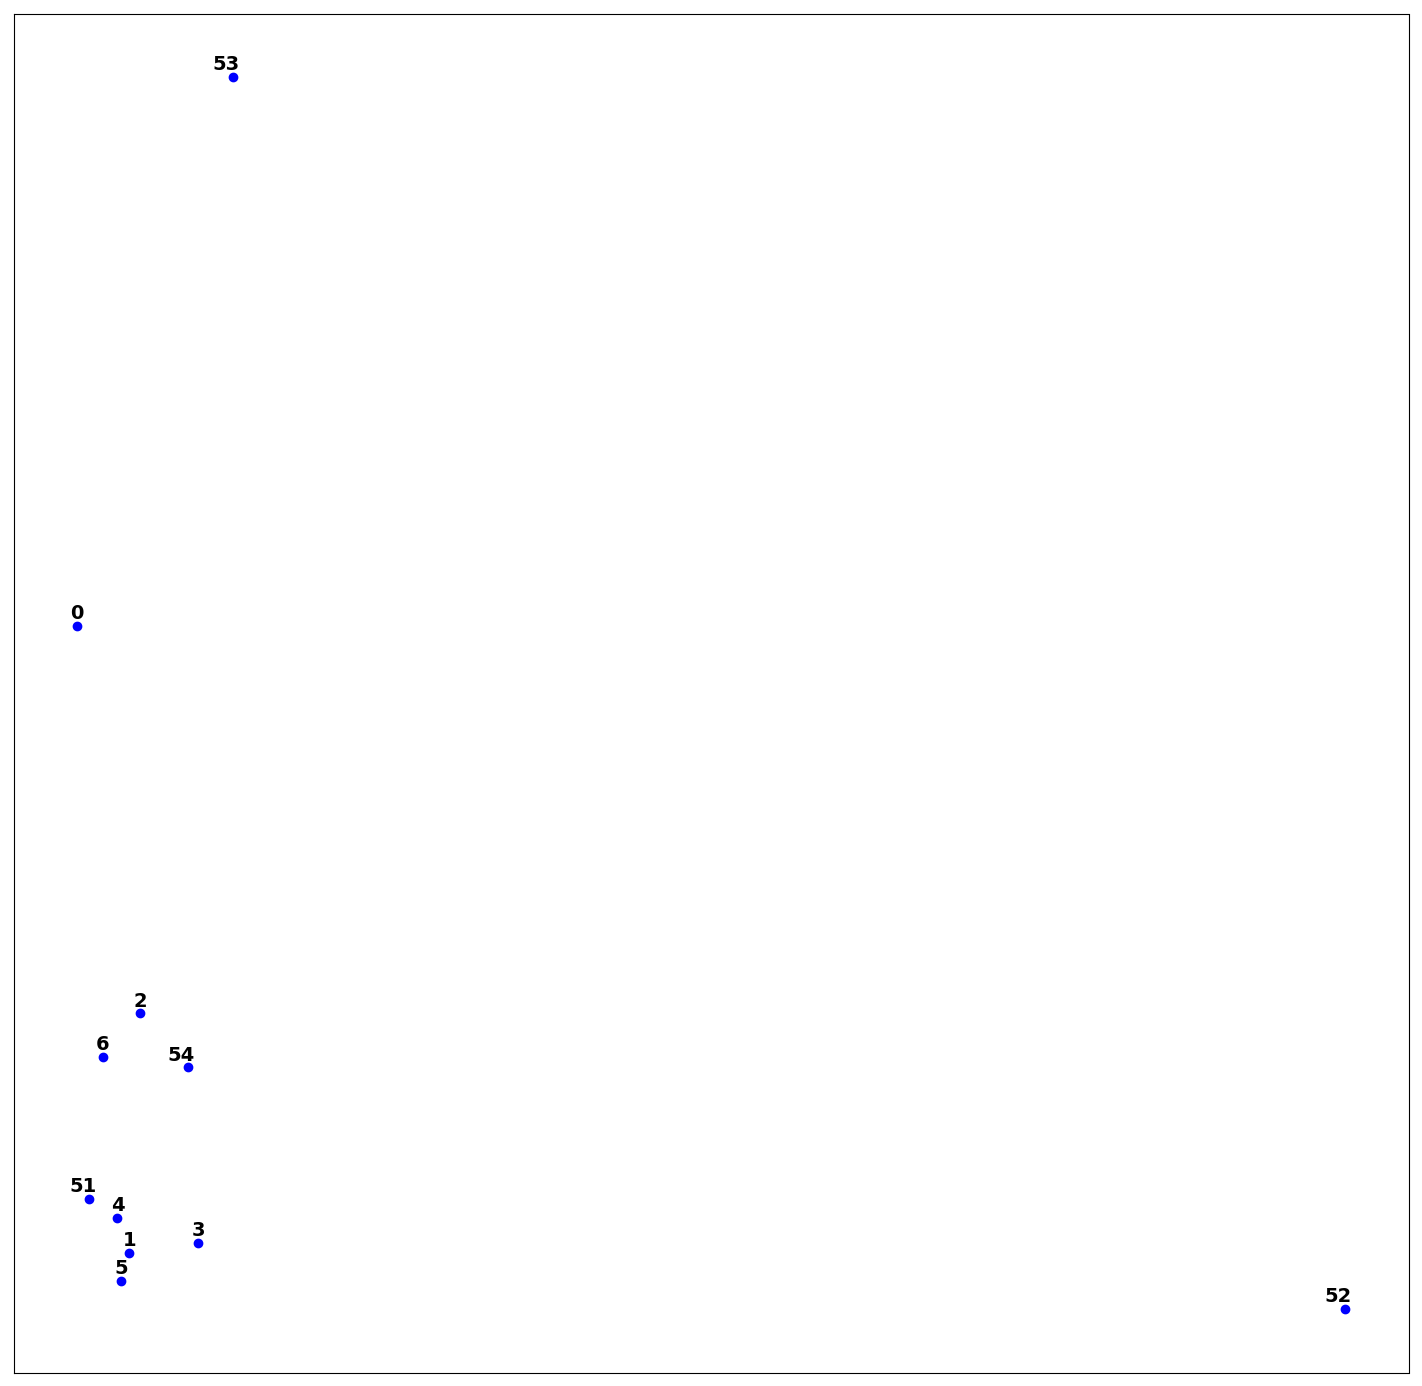

In [122]:
plot_embeddings(category_pca, id_to_category, category_top_words, figsize=(18, 18))

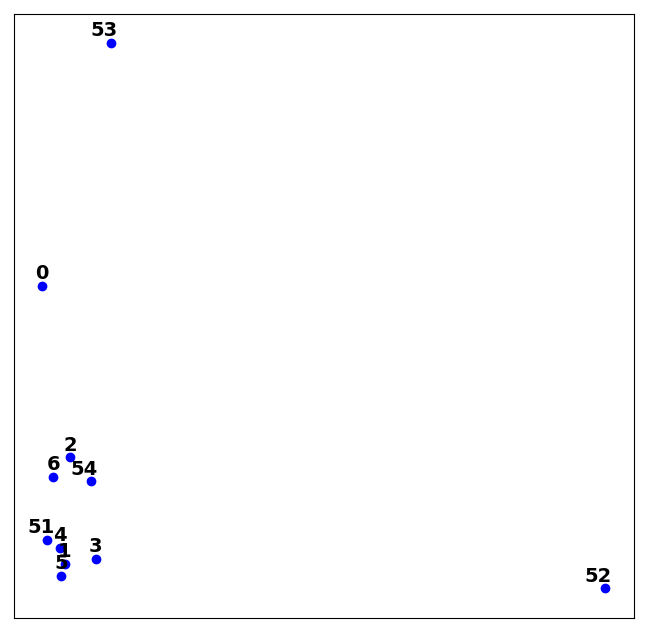

In [123]:
plot_embeddings(category_pca, id_to_category, get_top_words(category_t, 20))

## 3) Programs as Abstract Syntax Trees

In [124]:
# TODO

In [132]:
embeddings_scores

{'Category Token': {'accuracy': 0.53987294714753264,
  'loss': 0.7111181435142423},
 'Word': {'accuracy': 0.72730328837455682, 'loss': 0.53976663109980905},
 'Word Token': {'accuracy': 0.74195857966782053, 'loss': 0.51984683732987469}}

In [134]:
import json
with open('data/processed/embeddings_scores.json', 'w') as outfile:
    json.dump(embeddings_scores, outfile)

## SCORE

In [135]:
scores = json.load(open('data/processed/embeddings_scores.json'))

In [136]:
scores

{u'Category Token': {u'accuracy': 0.5398729471475326,
  u'loss': 0.7111181435142423},
 u'Word': {u'accuracy': 0.7273032883745568, u'loss': 0.539766631099809},
 u'Word Token': {u'accuracy': 0.7419585796678205, u'loss': 0.5198468373298747}}

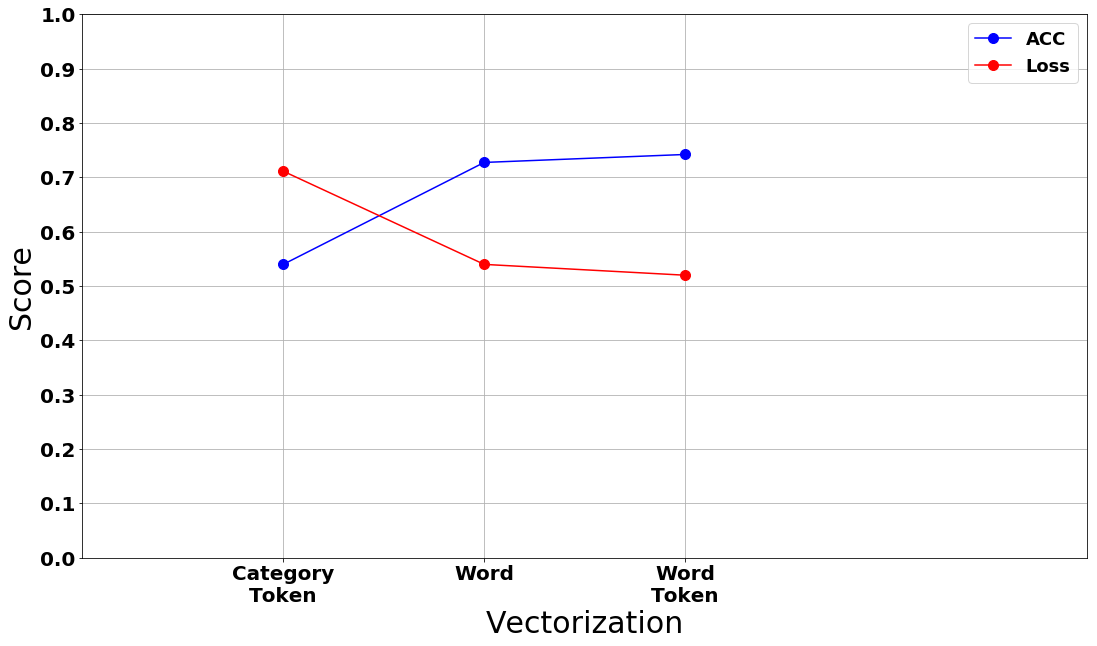

In [138]:
x = range(len(scores))
acc = [v['accuracy'] for k, v in scores.items()]
loss = [v['loss'] for k, v in scores.items()]
keys = [k.replace(' ', '\n') for k, v in scores.items()]

plt.subplots(figsize=(18, 10))
plt.grid()
plt.plot(x, acc, 'o-', color='b', label='ACC', markersize=10)
plt.plot(x, loss, 'o-', color='red', label='Loss', markersize=10)
plt.ylabel('Score', fontsize=30)
plt.xlabel('Vectorization', fontsize=30)
plt.xlim([-1, len(scores) + 1])
plt.xticks(x, keys)
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc="upper right", fontsize=18)